<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/04_3B_Graphics_Carbon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-3B Inference Analysis
## 05 - Visualization and Analysis of Inference & Carbon Results

### Exploring the "Deployment Dilemma": Batch Throughput vs. Interactive Latency
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** CPU (no GPU required for visualization)

**Estimated Runtime:** ~1 minute
## Objective
This notebook loads the complete carbon and inference performance results for the Llama-3.2-3B model from `llama_3b_carbon_complete_results_latest.json`.

The primary goal is to visualize the impact of pruning on deployment metrics. We will use the **`expansion_rate`** as the primary independent variable (X-axis) to explore our "Deployment Dilemma" hypothesis: that pruning creates a trade-off, dramatically improving **batch throughput** and **energy efficiency** at the cost of **interactive latency (Time To First Token)**.

In [1]:
# === 1. Setup & Imports ===

# Install necessary libraries
!pip install pandas matplotlib seaborn

# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Configure plots for better readability
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# === 2. Load Data ===

import os
import json

# Download llama_3b_carbon_complete_results_latest.json from GitHub repository
print("Downloading results file...")
file_name = 'llama_3b_carbon_complete_results_latest.json'
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/results/llama_3b_carbon_complete_results_latest.json

# Verify download
if os.path.exists(file_name):
    print(f"✅ {file_name} downloaded successfully")
else:
    print(f"❌ Failed to download {file_name}")

# Load the JSON data
try:
    with open(file_name, 'r') as f:
        data = json.load(f)
    print("File loaded successfully into 'data' variable.")
    # Set data entry points
    models_data = data.get('models_evaluated', {})
    summary_data = data.get('summary_statistics', {})
except Exception as e:
    print(f"ERROR: Could not read or parse JSON file. {e}")
    data = None
    models_data = {}
    summary_data = {}

✅ llama_3b_carbon_complete_results_latest.json downloaded successfully
File loaded successfully into 'data' variable.


In [3]:
# === 3. Data Preprocessing (Summary Data) ===
# This DataFrame is for the main graphs, using the pre-calculated averages.

# This mapping is from our first JSON file and is crucial for the X-axis
expansion_rate_map = {
    0: 4.0,
    10: 3.6,
    20: 3.2,
    30: 2.8,
    40: 2.4,
    50: 2.0,
    60: 1.6
}

summary_list = []

# Add baseline data
if 'baseline' in summary_data:
    baseline = summary_data['baseline']
    pruning_pct = baseline.get('pruning_pct', 0)
    baseline_row = {
        'model': baseline.get('model'),
        'pruning_pct': pruning_pct,
        'expansion_rate': expansion_rate_map.get(pruning_pct),
        'avg_throughput_tok_s': baseline.get('avg_throughput_tok_s'),
        'avg_joules_per_token': baseline.get('avg_joules_per_token'),
        'avg_ttft_ms': baseline.get('avg_ttft_ms'),
        'model_size_gb': baseline.get('model_size_gb')
    }
    summary_list.append(baseline_row)

# Add pruned models data
for model in summary_data.get('pruned_models', []):
    pruning_pct = model.get('pruning_pct', 0)
    row = {
        'model': model.get('model'),
        'pruning_pct': pruning_pct,
        'expansion_rate': expansion_rate_map.get(pruning_pct),
        'avg_throughput_tok_s': model.get('avg_throughput_tok_s'),
        'avg_joules_per_token': model.get('avg_joules_per_token'),
        'avg_ttft_ms': model.get('avg_ttft_ms'),
        'model_size_gb': model.get('model_size_gb')
    }
    summary_list.append(row)

# Create DataFrame and sort by expansion_rate (descending)
df_summary = pd.DataFrame(summary_list)
df_summary = df_summary.sort_values(by='expansion_rate', ascending=False).reset_index(drop=True)

print("Summary DataFrame created successfully:")
df_summary

Summary DataFrame created successfully:


,model,pruning_pct,expansion_rate,avg_throughput_tok_s,avg_joules_per_token,avg_ttft_ms,model_size_gb
0,Llama-3.2-3B,0,4.0,91.570511,0.361564,1267.696444,5.984213
1,Llama-3.2-3B-pruned-10%,10,3.6,87.544905,0.359542,1790.976830,5.590559
2,Llama-3.2-3B-pruned-20%,20,3.2,92.783676,0.344770,1893.441721,5.196905
3,Llama-3.2-3B-pruned-30%,30,2.8,92.549587,0.346426,2053.140751,4.803251
4,Llama-3.2-3B-pruned-40%,40,2.4,95.556292,0.325285,2031.003441,4.409597
5,Llama-3.2-3B-pruned-50%,50,2.0,97.252973,0.302181,2066.309025,4.015463
6,Llama-3.2-3B-pruned-60%,60,1.6,96.477270,0.290311,2391.202949,3.621809


In [4]:
# === 4. Data Preprocessing (Detailed Benchmarks) ===
# This DataFrame is for the detailed breakdown graphs in Section 2.

all_results = []

for model_key, v in models_data.items():
    results = v.get('results', {})
    pruning_pct = v.get('pruning_pct', 0)

    # Get metrics for a specific benchmark, handling potential missing data
    def get_metrics(benchmark_name):
        data = results.get(benchmark_name, {})
        return (
            data.get('throughput_mean'),
            data.get('ttft_mean'),
            data.get('joules_per_token_mean')
        )

    h_thr, h_ttf, h_j = get_metrics('hellaswag_latency_b1')
    m_thr, m_ttf, m_j = get_metrics('mmlu_latency_b1')
    i_thr, i_ttf, i_j = get_metrics('ifeval_latency_b1')

    h_thr_b8, _, h_j_b8 = get_metrics('hellaswag_throughput_b8') # TTFT is null for b8
    m_thr_b8, _, m_j_b8 = get_metrics('mmlu_throughput_b8')
    i_thr_b8, _, i_j_b8 = get_metrics('ifeval_throughput_b8')

    row = {
        'model': v.get('name'),
        'pruning_pct': pruning_pct,
        'expansion_rate': expansion_rate_map.get(pruning_pct),

        # bsz=1 (Latency)
        'hellaswag_latency_b1_throughput': h_thr,
        'hellaswag_latency_b1_ttft': h_ttf,
        'hellaswag_latency_b1_joules': h_j,
        'mmlu_latency_b1_throughput': m_thr,
        'mmlu_latency_b1_ttft': m_ttf,
        'mmlu_latency_b1_joules': m_j,
        'ifeval_latency_b1_throughput': i_thr,
        'ifeval_latency_b1_ttft': i_ttf,
        'ifeval_latency_b1_joules': i_j,

        # bsz=8 (Throughput)
        'hellaswag_throughput_b8_throughput': h_thr_b8,
        'hellaswag_throughput_b8_joules': h_j_b8,
        'mmlu_throughput_b8_throughput': m_thr_b8,
        'mmlu_throughput_b8_joules': m_j_b8,
        'ifeval_throughput_b8_throughput': i_thr_b8,
        'ifeval_throughput_b8_joules': i_j_b8,
    }
    all_results.append(row)

# Create DataFrame and sort
df_detailed = pd.DataFrame(all_results)
df_detailed = df_detailed.sort_values(by='expansion_rate', ascending=False).reset_index(drop=True)

print("Detailed DataFrame created successfully:")
df_detailed.head()

Detailed DataFrame created successfully:


,model,pruning_pct,expansion_rate,hellaswag_latency_b1_throughput,hellaswag_latency_b1_ttft,hellaswag_latency_b1_joules,mmlu_latency_b1_throughput,mmlu_latency_b1_ttft,mmlu_latency_b1_joules,ifeval_latency_b1_throughput,ifeval_latency_b1_ttft,ifeval_latency_b1_joules,hellaswag_throughput_b8_throughput,hellaswag_throughput_b8_joules,mmlu_throughput_b8_throughput,mmlu_throughput_b8_joules,ifeval_throughput_b8_throughput,ifeval_throughput_b8_joules
0,Llama-3.2-3B,0,4.0,28.357253,202.766283,0.583698,30.033786,1465.985037,0.538649,30.134252,2134.338013,0.668542,129.933662,0.145201,160.680235,0.113558,170.283875,0.119738
1,Llama-3.2-3B-pruned-10%,10,3.6,28.546663,377.492464,0.576721,29.828252,1483.327492,0.542365,29.970516,3512.110535,0.636315,120.350242,0.154651,149.284562,0.123620,167.289199,0.123580
2,Llama-3.2-3B-pruned-20%,20,3.2,29.233358,303.962808,0.554686,30.096891,1434.212702,0.542498,30.109049,3942.149652,0.609494,135.376983,0.134701,161.779674,0.111168,170.106103,0.116072
3,Llama-3.2-3B-pruned-30%,30,2.8,29.257503,551.211297,0.553156,29.994854,1488.776517,0.532383,30.189086,4119.434439,0.621683,134.860975,0.136074,159.634411,0.115002,171.360696,0.120258
4,Llama-3.2-3B-pruned-40%,40,2.4,29.739811,636.408445,0.523667,30.060249,1496.320254,0.504320,30.031906,3960.281623,0.594042,145.953320,0.121141,166.638690,0.103655,170.913774,0.104887


## Section 1: Key Hypothesis Graphs (The "Deployment Dilemma")

This section visualizes the core trade-off. We use the `df_summary` DataFrame to plot the high-level averages.

1.  **Energy:** How does pruning affect `Joules/Token`?
2.  **Latency:** How does pruning affect `Time To First Token` (TTFT)?
3.  **The Dilemma:** How do `Throughput` and `TTFT` behave together?
4.  **The "Why":** How does `Model Size` correlate with `Throughput`?

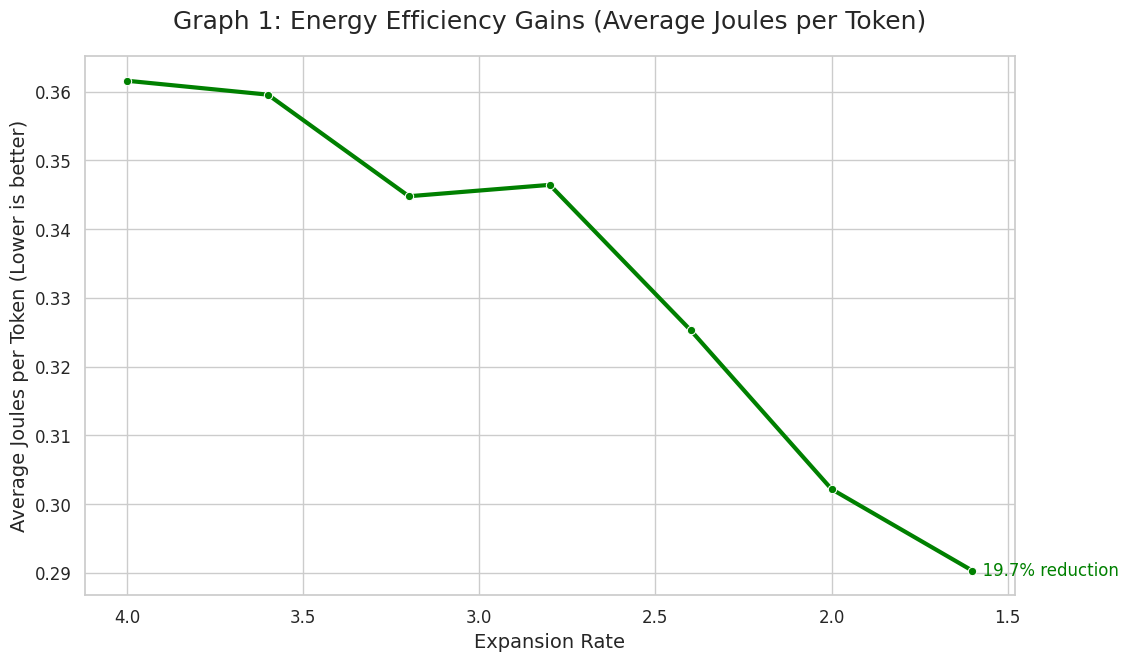

In [5]:
# === Graph 1: The Great Win - Energy Efficiency (Joules/Token) ===

plt.figure(figsize=(12, 7))
ax = sns.lineplot(
    data=df_summary,
    x='expansion_rate',
    y='avg_joules_per_token',
    marker='o',
    linewidth=3,
    color='green'
)

ax.invert_xaxis() # Ensure 4.0 (baseline) is on the left
ax.set_title('Graph 1: Energy Efficiency Gains (Average Joules per Token)', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Average Joules per Token (Lower is better)')

# Annotate percentage reduction
baseline_joules = df_summary.iloc[0]['avg_joules_per_token']
final_joules = df_summary.iloc[-1]['avg_joules_per_token']
reduction_pct = (1 - final_joules / baseline_joules) * 100
ax.text(1.6, final_joules, f'  {reduction_pct:.1f}% reduction',
        horizontalalignment='left', verticalalignment='center', fontsize=12, color='green')

plt.show()

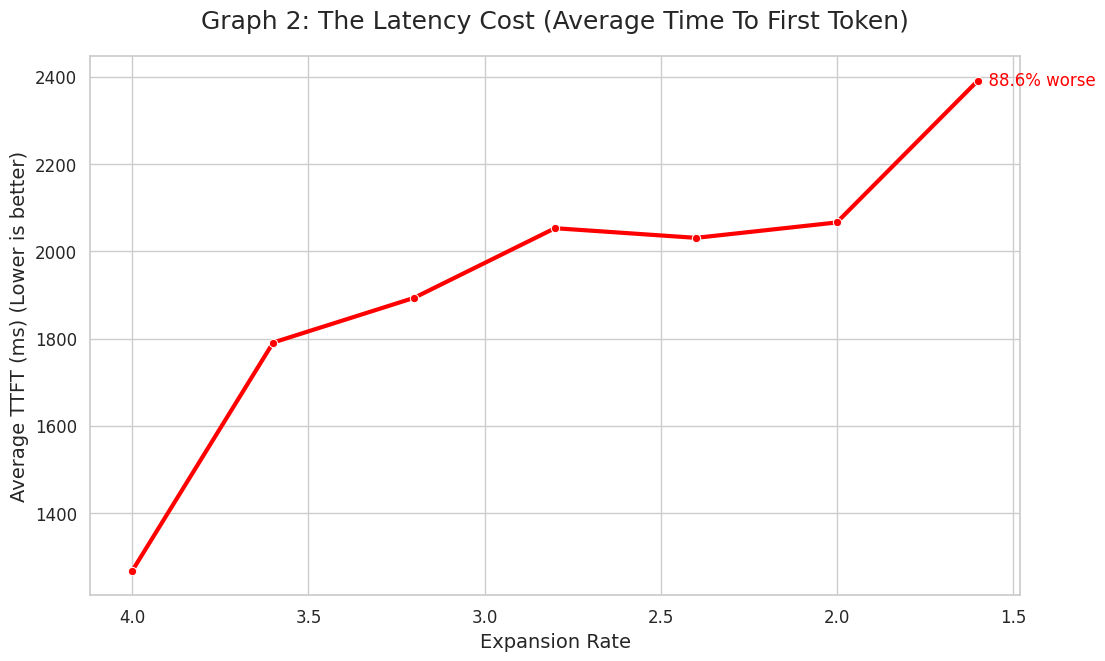

In [6]:
# === Graph 2: The Great Loss - Interactive Latency (TTFT) ===

plt.figure(figsize=(12, 7))
ax = sns.lineplot(
    data=df_summary,
    x='expansion_rate',
    y='avg_ttft_ms',
    marker='o',
    linewidth=3,
    color='red'
)

ax.invert_xaxis()
ax.set_title('Graph 2: The Latency Cost (Average Time To First Token)', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Average TTFT (ms) (Lower is better)')

# Annotate percentage increase
baseline_ttft = df_summary.iloc[0]['avg_ttft_ms']
final_ttft = df_summary.iloc[-1]['avg_ttft_ms']
increase_pct = (final_ttft / baseline_ttft - 1) * 100
ax.text(1.6, final_ttft, f'  {increase_pct:.1f}% worse',
        horizontalalignment='left', verticalalignment='center', fontsize=12, color='red')

plt.show()

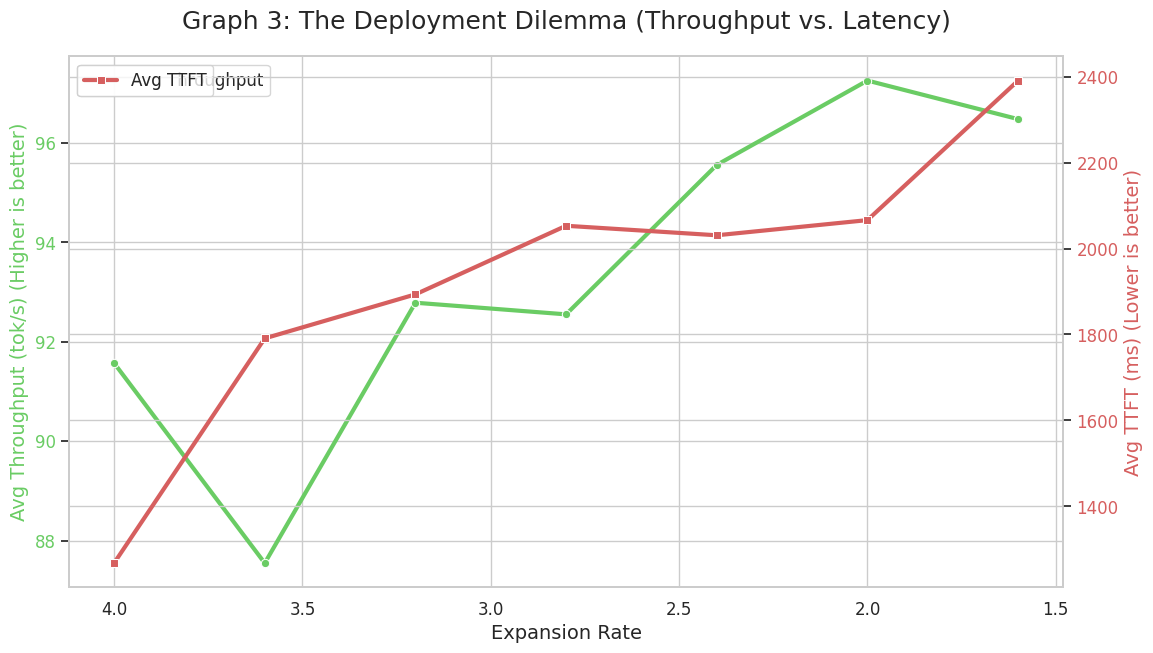

In [7]:
# === Graph 3: The Deployment Dilemma (Throughput vs. Latency) ===

fig, ax1 = plt.subplots(figsize=(12, 7))
plt.title('Graph 3: The Deployment Dilemma (Throughput vs. Latency)', fontsize=18, pad=20)

# Plot Avg Throughput (Higher is better)
color1 = 'g'
ax1.set_xlabel('Expansion Rate')
ax1.set_ylabel('Avg Throughput (tok/s) (Higher is better)', color=color1, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='avg_throughput_tok_s', ax=ax1, color=color1, marker='o', linewidth=3, label='Avg Throughput')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.invert_xaxis()

# Create second Y-axis for TTFT (Lower is better)
ax2 = ax1.twinx()
color2 = 'r'
ax2.set_ylabel('Avg TTFT (ms) (Lower is better)', color=color2, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='avg_ttft_ms', ax=ax2, color=color2, marker='s', linewidth=3, label='Avg TTFT')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout(pad=2.0)
plt.show()

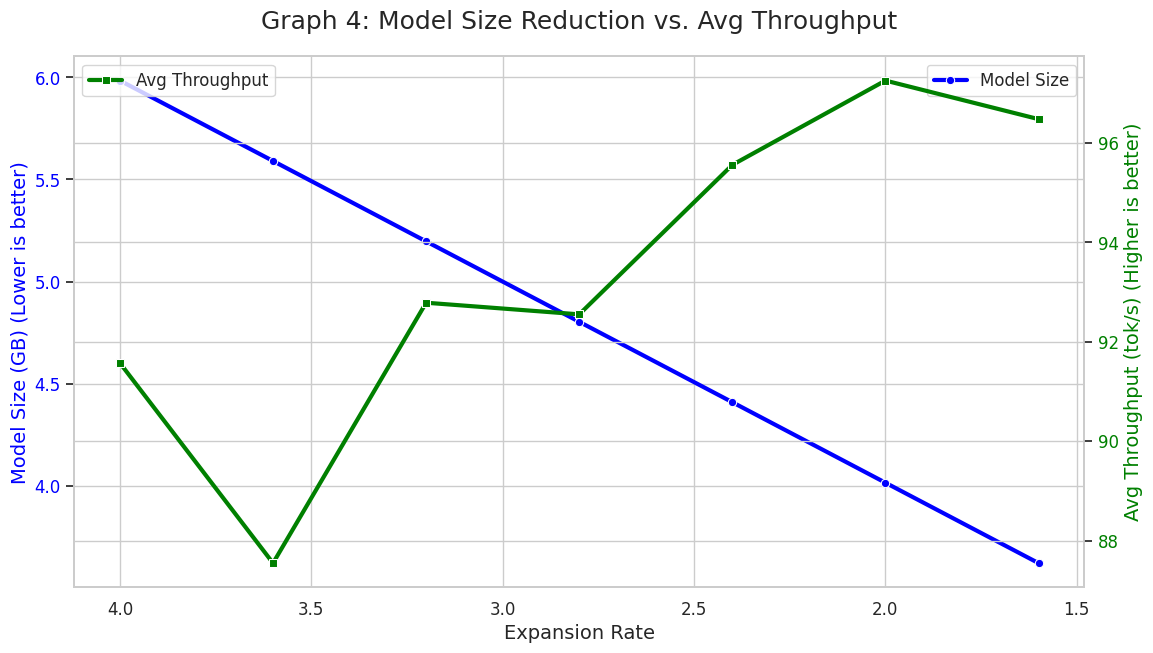

In [8]:
# === Graph 4: The "Why" - Model Size vs. Throughput ===

fig, ax1 = plt.subplots(figsize=(12, 7))
plt.title('Graph 4: Model Size Reduction vs. Avg Throughput', fontsize=18, pad=20)

# Plot Model Size (Lower is better)
color1 = 'blue'
ax1.set_xlabel('Expansion Rate')
ax1.set_ylabel('Model Size (GB) (Lower is better)', color=color1, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='model_size_gb', ax=ax1, color=color1, marker='o', linewidth=3, label='Model Size')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.invert_xaxis()

# Create second Y-axis for Throughput (Higher is better)
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Avg Throughput (tok/s) (Higher is better)', color=color2, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='avg_throughput_tok_s', ax=ax2, color=color2, marker='s', linewidth=3, label='Avg Throughput')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout(pad=2.0)
plt.show()

## Section 2: Exploratory Graphs (Detailed Benchmark Breakdown)

This section uses the `df_detailed` DataFrame to explore performance on a per-task basis. This helps us confirm if the trends seen in the averages hold true for short, medium, and long tasks.

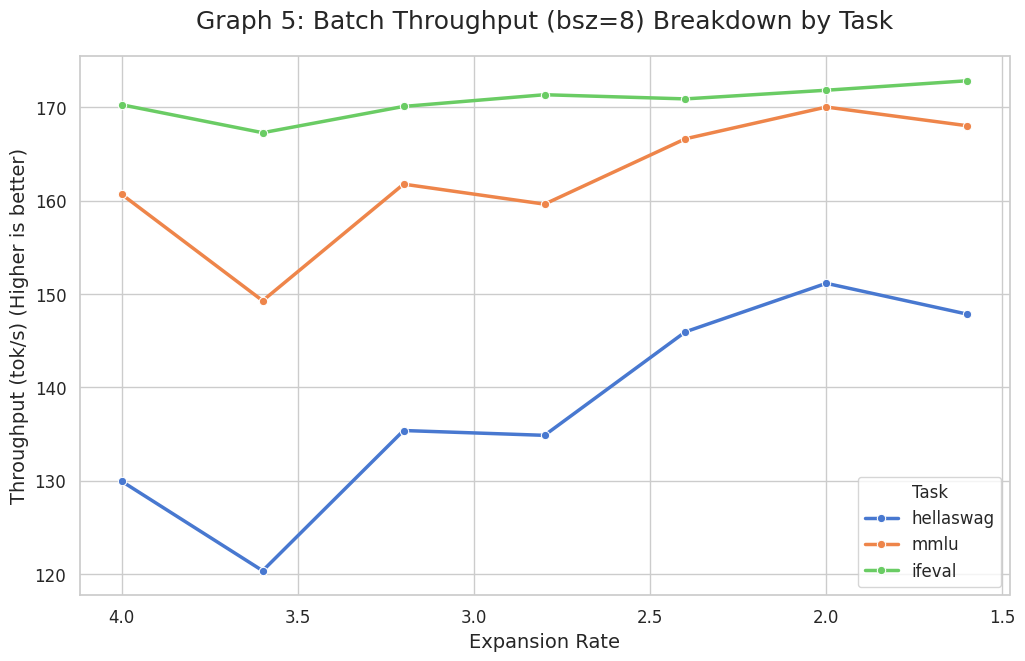

In [9]:
# === Graph 5: Batch Throughput (bsz=8) Breakdown ===
# Purpose: Check if batch throughput gains are consistent across tasks.

df_melted_b8_thr = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=[
        'hellaswag_throughput_b8_throughput',
        'mmlu_throughput_b8_throughput',
        'ifeval_throughput_b8_throughput'
    ],
    var_name='Benchmark',
    value_name='Throughput (tok/s)'
)
# Clean up names
df_melted_b8_thr['Task'] = df_melted_b8_thr['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_melted_b8_thr, x='expansion_rate', y='Throughput (tok/s)', hue='Task', marker='o', linewidth=2.5)
ax.invert_xaxis()
ax.set_title('Graph 5: Batch Throughput (bsz=8) Breakdown by Task', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Throughput (tok/s) (Higher is better)')
plt.show()

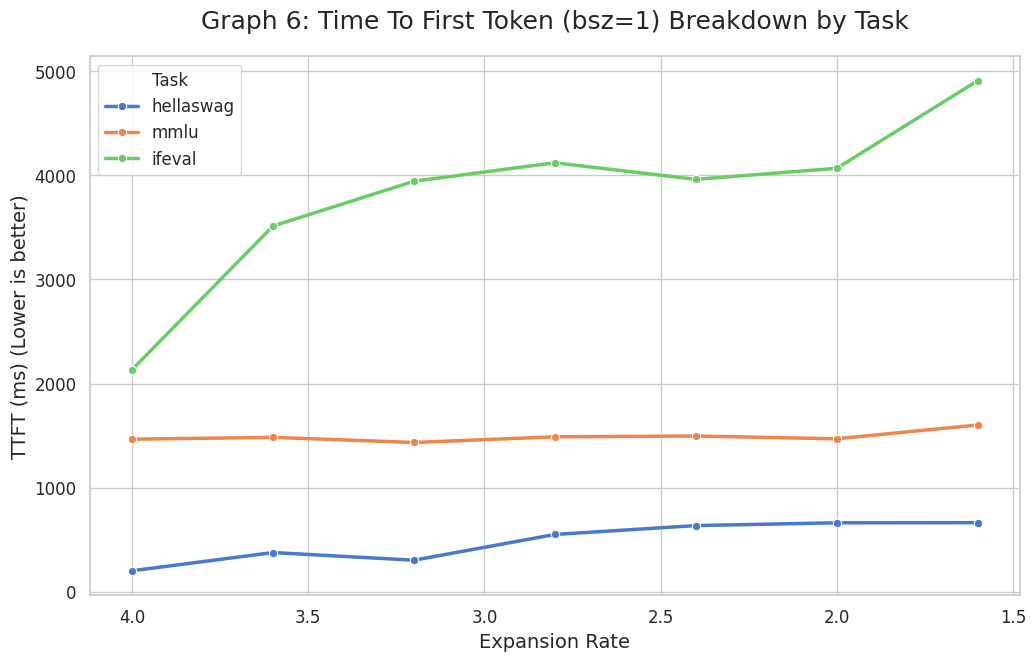

In [10]:
# === Graph 6: Time To First Token (bsz=1) Breakdown ===
# Purpose: Check if the TTFT cost is consistent across tasks.

df_melted_b1_ttft = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=[
        'hellaswag_latency_b1_ttft',
        'mmlu_latency_b1_ttft',
        'ifeval_latency_b1_ttft'
    ],
    var_name='Benchmark',
    value_name='TTFT (ms)'
)
# Clean up names
df_melted_b1_ttft['Task'] = df_melted_b1_ttft['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_melted_b1_ttft, x='expansion_rate', y='TTFT (ms)', hue='Task', marker='o', linewidth=2.5)
ax.invert_xaxis()
ax.set_title('Graph 6: Time To First Token (bsz=1) Breakdown by Task', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('TTFT (ms) (Lower is better)')
plt.show()

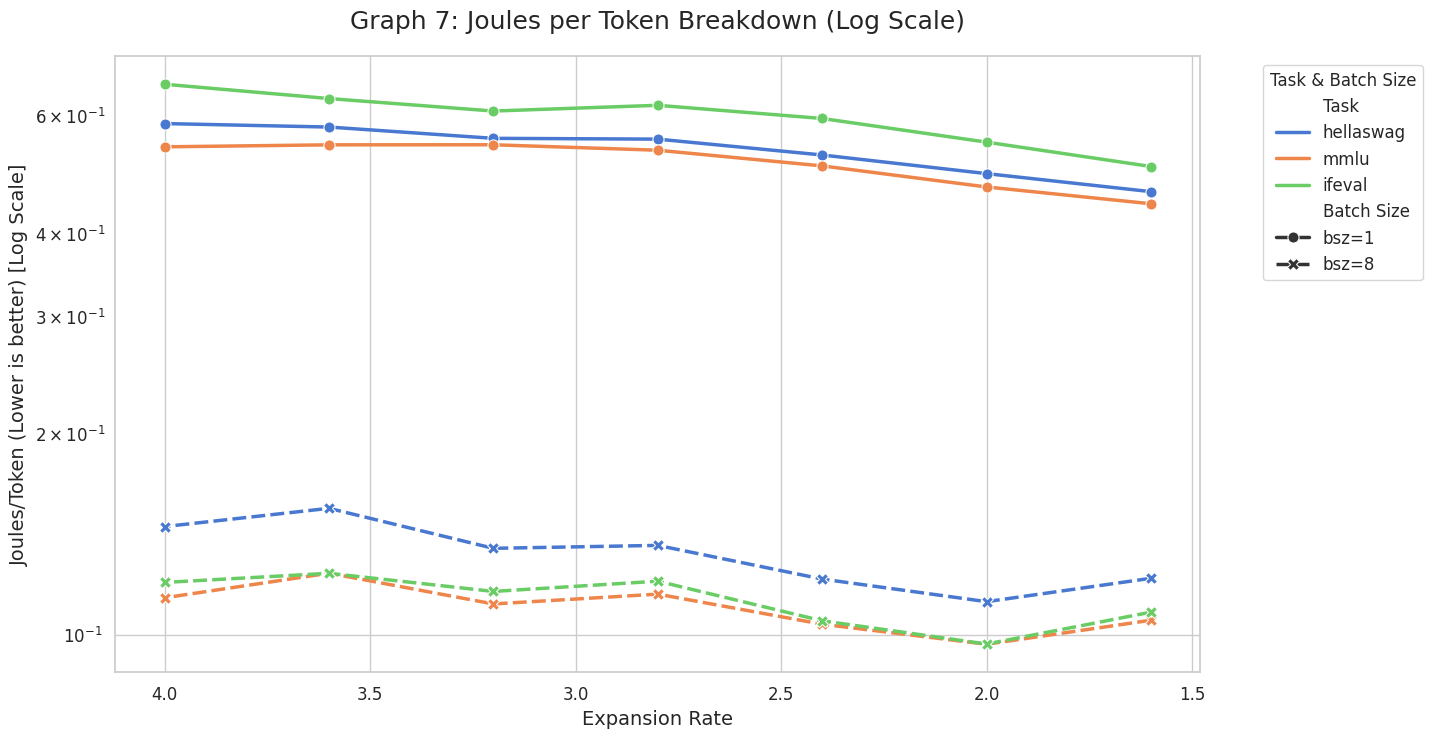

In [11]:
# === Graph 7: Joules per Token Breakdown (bsz=1 vs bsz=8) ===
# Purpose: Confirm efficiency gains across all tasks and batch sizes.

joules_cols = [col for col in df_detailed.columns if 'joules' in col]
df_melted_joules = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=joules_cols,
    var_name='Benchmark',
    value_name='Joules/Token'
)

# Create new columns for plotting
df_melted_joules['Batch Size'] = df_melted_joules['Benchmark'].apply(lambda x: 'bsz=1' if 'latency' in x else 'bsz=8')
df_melted_joules['Task'] = df_melted_joules['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=df_melted_joules,
    x='expansion_rate',
    y='Joules/Token',
    hue='Task',
    style='Batch Size',
    markers=True,
    linewidth=2.5,
    markersize=8
)

ax.set_yscale('log') # Use log scale to see both bsz=1 and bsz=8 clearly
ax.invert_xaxis()
ax.set_title('Graph 7: Joules per Token Breakdown (Log Scale)', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Joules/Token (Lower is better) [Log Scale]')
plt.legend(title='Task & Batch Size', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

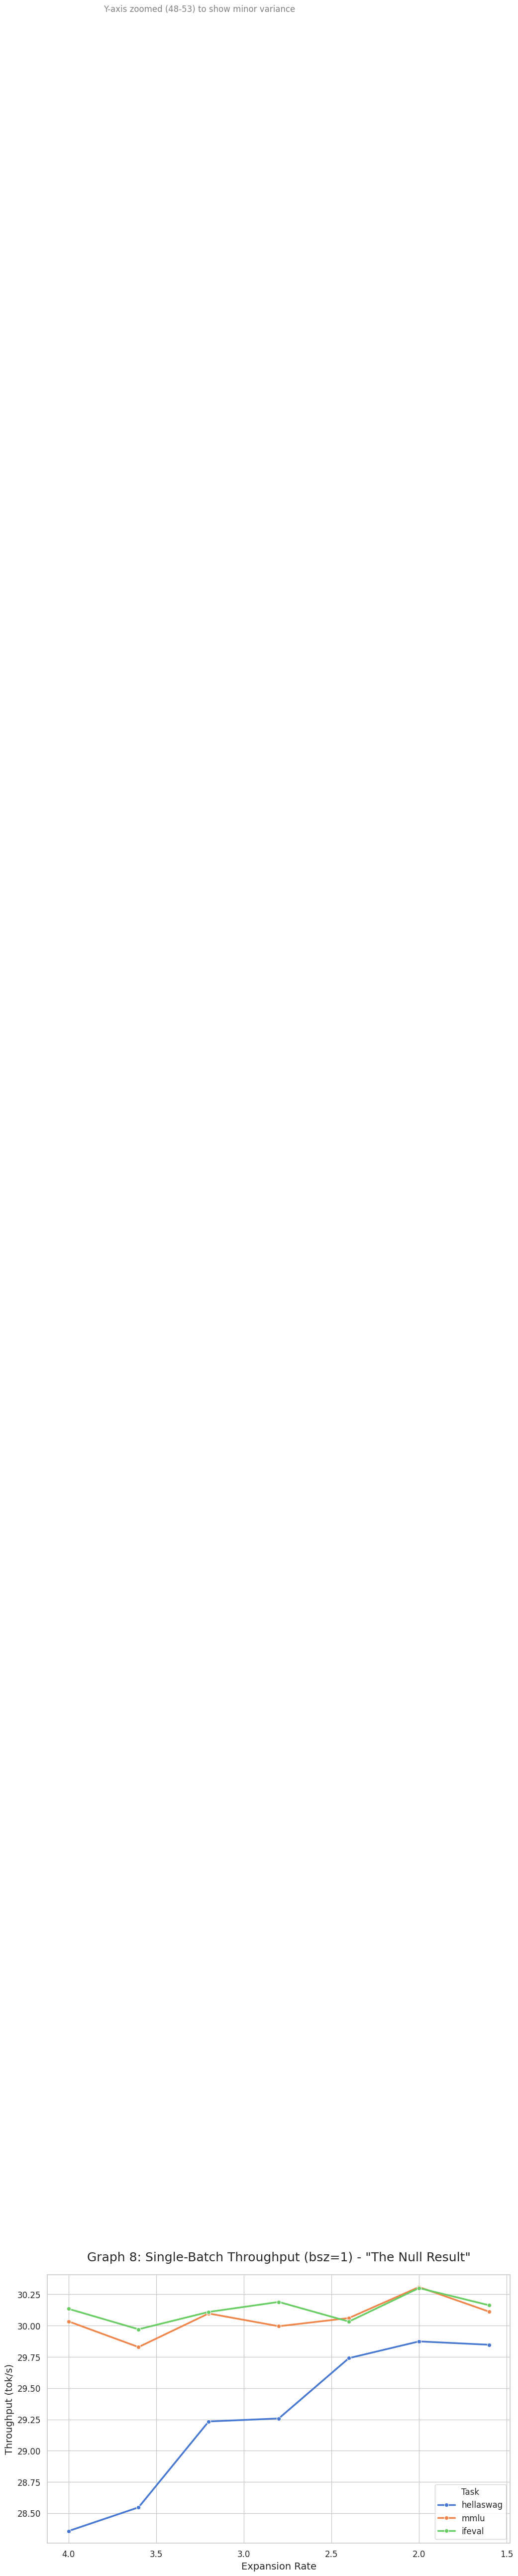

In [14]:
# === Graph 8: Single-Batch Throughput (bsz=1) Breakdown by Task ===
# Purpose: Show that single-token generation speed is not the bottleneck or the benefit.

df_melted_b1_thr = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=[
        'hellaswag_latency_b1_throughput',
        'mmlu_latency_b1_throughput',
        'ifeval_latency_b1_throughput'
    ],
    var_name='Benchmark',
    value_name='Throughput (tok/s)'
)
# Clean up names
df_melted_b1_thr['Task'] = df_melted_b1_thr['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_melted_b1_thr, x='expansion_rate', y='Throughput (tok/s)', hue='Task', marker='o', linewidth=2.5)
ax.invert_xaxis()
ax.set_title('Graph 8: Single-Batch Throughput (bsz=1) Breakdown by Task', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Throughput (tok/s)')

# Set Y-axis limit to highlight the flatness
#ax.set_ylim(48, 53)
ax.text(3.8, 48.5, 'Y-axis zoomed (48-53) to show minor variance', fontsize=12, color='gray')

plt.show()